In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload

In [10]:
%autoreload 1

## EDA

In [3]:
%aimport utils.eda
from utils.eda import (extract_image_props_all,
                      get_random_images,
                      show_images,
                      multivariate_grid,
                      plot_average_intensity_histograms)

In [4]:
DIR = './Covid19-dataset'

In [5]:
# Get all images props takes a long time. If img_properties.json exists, load it. If not, generate it and save it.
if os.path.exists('img_properties.json'):
  df_img_props = pd.read_json('img_properties.json')
else:
  df_img_props = extract_image_props_all(DIR)
  df_img_props.to_json('img_properties.json')

df_img_props.head()

,datasplit,path,label,xsize,ysize,br_med,br_std,intens,aspectratio_yx
0,test,./Covid19-dataset/test/Normal/0119.jpeg,normal,1936,1554,102,82.633978,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 8, 19, 31...",0.802686
1,test,./Covid19-dataset/test/Normal/0114.jpeg,normal,1796,1372,113,80.080781,"[1, 3, 6, 9, 12, 15, 17, 20, 23, 27, 32, 36, 3...",0.763920
2,test,./Covid19-dataset/test/Normal/0107.jpeg,normal,1816,1435,118,78.683250,"[1, 2, 5, 10, 14, 23, 34, 42, 53, 62, 67, 69, ...",0.790198
3,test,./Covid19-dataset/test/Normal/0105.jpeg,normal,1670,1319,127,74.541684,"[22, 24, 24, 27, 33, 33, 37, 59, 75, 90, 105, ...",0.789820
4,test,./Covid19-dataset/test/Normal/0118.jpeg,normal,1844,1504,115,79.527165,"[0, 2, 3, 6, 13, 15, 22, 30, 41, 49, 50, 56, 6...",0.815618


- ### Size Distribution for all datasets

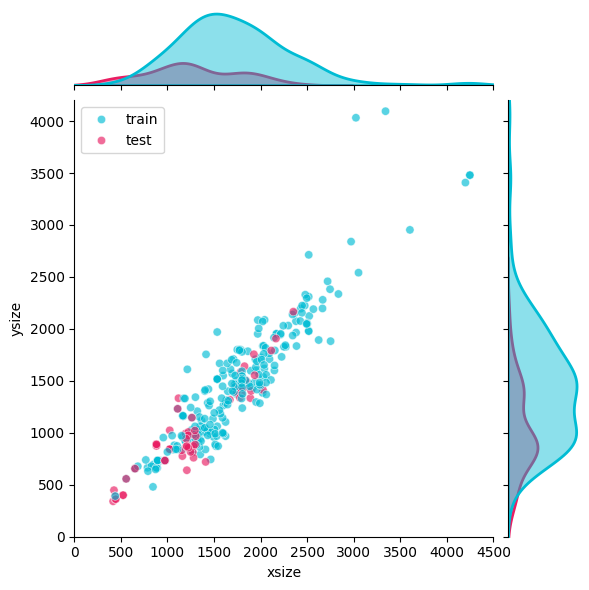

In [6]:
multivariate_grid(df_img_props, 'xsize', 'ysize', lim={'x': (0, 4500), 'y': (0, 4200)})

- ### Aspect ratio distribution

In [34]:
custom_colors = ['#009688', '#00BCD4', '#03A9F4', '#3F51B5', '#673AB7', '#9C27B0', '#E91E63']

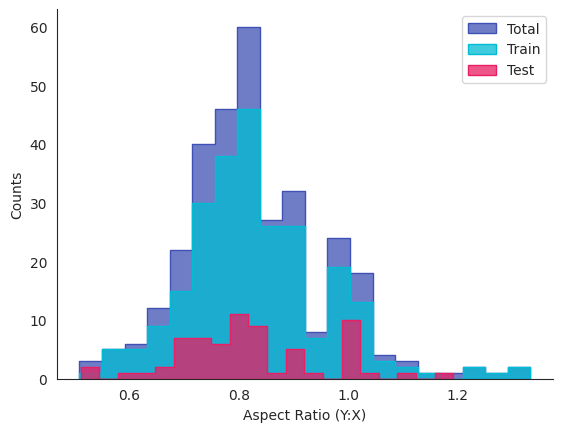

In [8]:
sns.set_style("white")
bins = 20
sns.histplot(df_img_props, x='aspectratio_yx', bins=bins, color=custom_colors[3], element='step', stat='count', common_norm=False, label='Total')
sns.histplot(df_img_props[df_img_props.datasplit == 'train'], x='aspectratio_yx', bins=bins, color=custom_colors[1], element='step', stat='count', common_norm=False, label='Train')
sns.histplot(df_img_props[df_img_props.datasplit == 'test'], x='aspectratio_yx', bins=bins, color=custom_colors[6], element='step', stat='count', common_norm=False, label='Test')

plt.legend()
plt.xlabel('Aspect Ratio (Y:X)')
plt.ylabel('Counts')
sns.despine()

plt.show()


- ### Train-Test split distribution

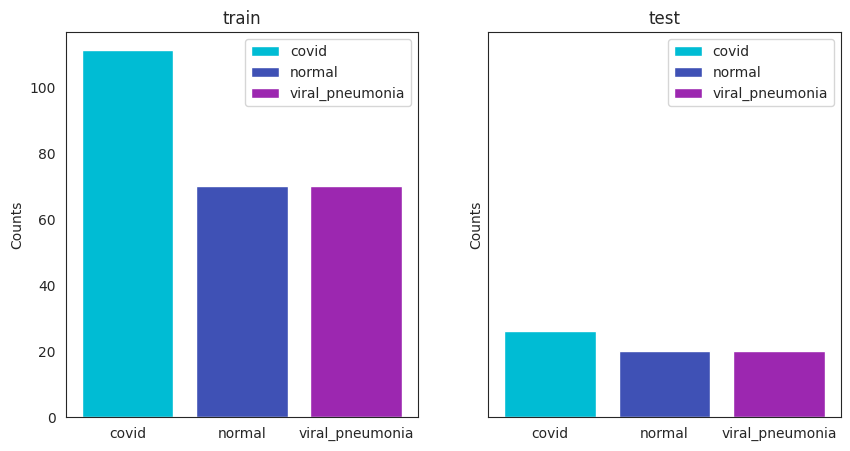

In [9]:
label_colors = {'covid': custom_colors[1], 'normal': custom_colors[3], 'viral_pneumonia': custom_colors[5]}
fig, axes = plt.subplots(nrows=1, ncols=len(df_img_props['datasplit'].unique()), figsize=(10, 5), sharey=True)

for i, datasplit in enumerate(df_img_props['datasplit'].unique()):
    split_data = df_img_props[df_img_props['datasplit'] == datasplit]
    ax = axes[i]
    
    for label, color in label_colors.items():
        label_data = split_data[split_data['label'] == label]
        ax.bar(label, label_data.shape[0], color=color, label=label)

    ax.set_title(datasplit)
    ax.set_ylabel('Counts')
    ax.legend()
    ax.grid(False)

plt.show()


- ### Distribution of median brightnesses

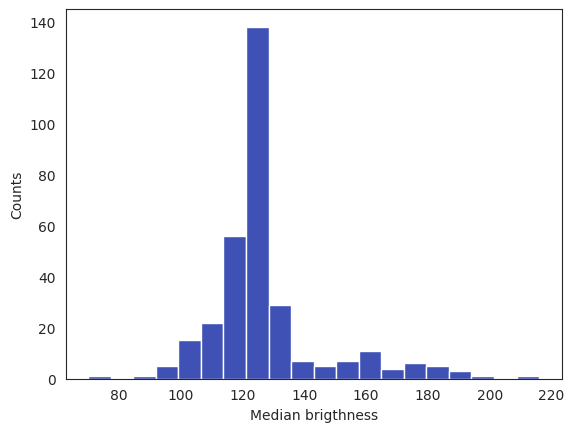

In [80]:
df_img_props.br_med.hist(grid=False, bins=20, color=custom_colors[3])
plt.xlabel('Median brigthness')
plt.ylabel('Counts')
plt.show()

- ### Pixel intensity

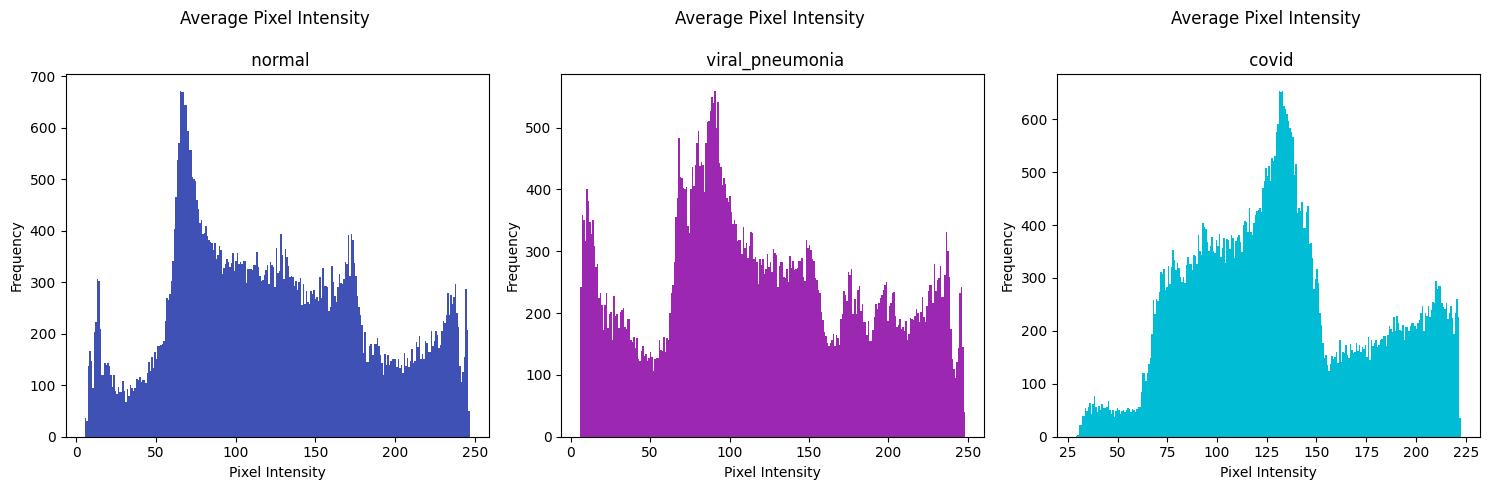

In [49]:
plot_average_intensity_histograms(df_img_props, labels=('normal', 'viral_pneumonia', 'covid'))

- ### Image inspection

TRAIN
	Normal


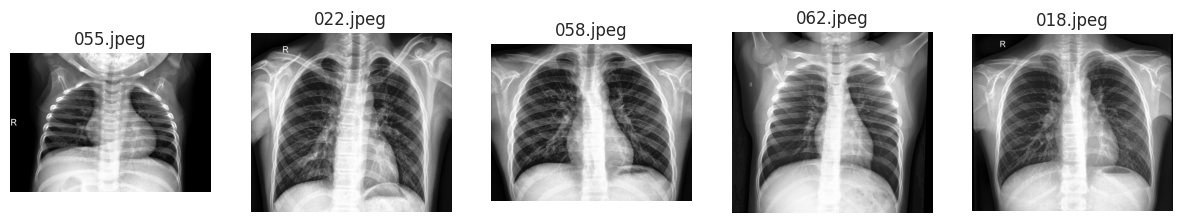

	Viral Pneumonia


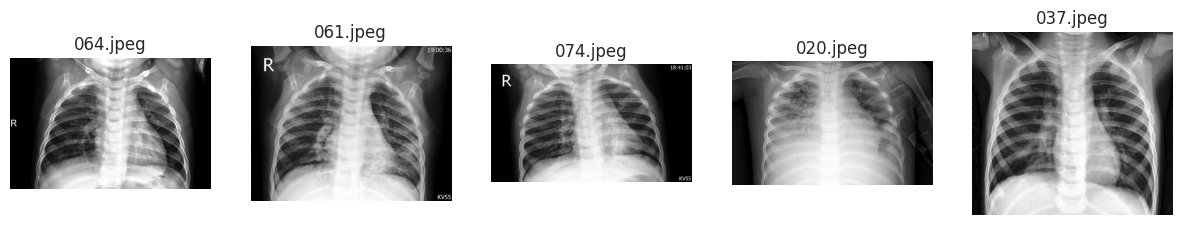

	Covid


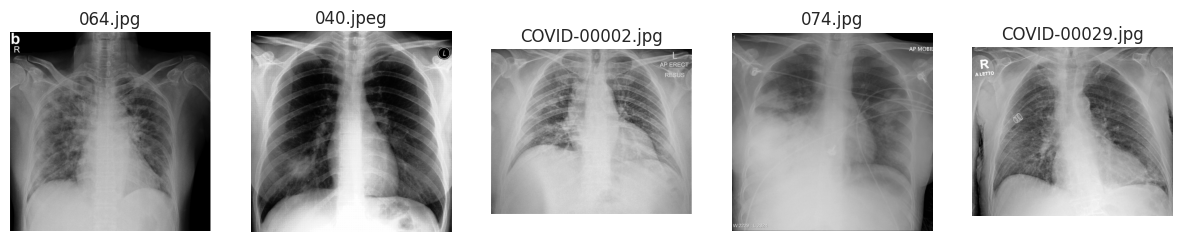

TEST
	Normal


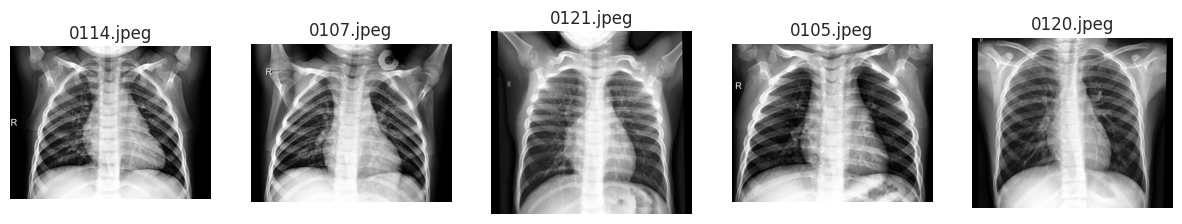

	Viral Pneumonia


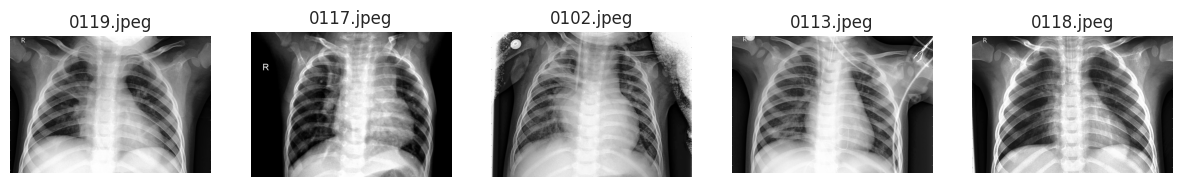

	Covid


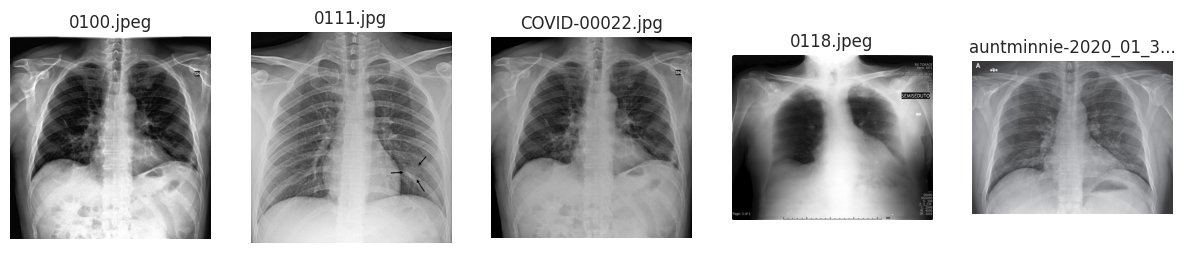

In [82]:
for split in ('train', 'test'):
  img_paths = get_random_images(df_img_props, split, nsize=5)
  print(split.upper())
  
  for imgs in img_paths:
    show_images(imgs)

## Train Model

In [1]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

2023-12-14 01:58:19.956171: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 01:58:20.481092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 01:58:20.481150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 01:58:20.588563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 01:58:20.819404: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 01:58:20.822775: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
train_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  validation_split=0.25
)

train_ds = train_gen.flow_from_directory(
  './Covid19-dataset/train',
  target_size=(150, 150),
  batch_size=32,
  subset='training'
)

Found 190 images belonging to 3 classes.


In [5]:
train_ds.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [6]:
val_ds = train_gen.flow_from_directory(
  './Covid19-dataset/train',
  target_size=(150, 150),
  batch_size=32,
  shuffle=False,
  subset='validation'  
)

Found 61 images belonging to 3 classes.


- ### V1 

In [17]:
%aimport utils.train
from utils.train import make_model

In [18]:
INP_SIZE = 150
model = make_model(input_size=INP_SIZE, inner=False, learning_rate=0.01)

2023-12-14 02:08:41.385383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 02:08:41.437711: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
history = model.fit(
  train_ds,
  epochs=10,
  validation_data=val_ds,
)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.9474 - accuracy: 0.5684

/home/marcelonieva/.local/share/virtualenvs/chest-3rfJv5kz/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 11s 2s/step - loss: 1.9474 - accuracy: 0.5684 - val_loss: 1.1669 - val_accuracy: 0.7213
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.7096 - accuracy: 0.8368 - val_loss: 0.9642 - val_accuracy: 0.8689
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.3794 - accuracy: 0.9053 - val_loss: 0.7052 - val_accuracy: 0.8689
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.2415 - accuracy: 0.9421 - val_loss: 0.6587 - val_accuracy: 0.8689
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 0.1167 - accuracy: 0.9684 - val_loss: 0.7244 - val_accuracy: 0.8525
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.0591 - accuracy: 0.9842 - val_loss: 0.7798 - val_accuracy: 0.8689
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.0304 - accuracy: 0.9895 - val_loss: 0.7473 - val_accuracy: 0.8361
Epoch 8/10
6/6 [==============================] - 7

- ### V2: tunning learning rate

In [25]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print('LR: ', lr)

  model = make_model(input_size=INP_SIZE, inner=False, learning_rate=lr)
  history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
  )
  scores[lr] = history.history

  print('=============================================\n')

LR:  0.0001


Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.4947

/home/marcelonieva/.local/share/virtualenvs/chest-3rfJv5kz/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 11s 1s/step - loss: 1.0159 - accuracy: 0.4947 - val_loss: 0.9274 - val_accuracy: 0.5574
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.9096 - accuracy: 0.6000 - val_loss: 0.8500 - val_accuracy: 0.6885
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.8269 - accuracy: 0.6632 - val_loss: 0.7902 - val_accuracy: 0.7049
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.7674 - accuracy: 0.6947 - val_loss: 0.7395 - val_accuracy: 0.7377
Epoch 5/10
6/6 [==============================] - 6s 1s/step - loss: 0.7088 - accuracy: 0.7368 - val_loss: 0.6981 - val_accuracy: 0.7377
Epoch 6/10
6/6 [==============================] - 6s 1s/step - loss: 0.6622 - accuracy: 0.7789 - val_loss: 0.6627 - val_accuracy: 0.7377
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.6198 - accuracy: 0.8000 - val_loss: 0.6325 - val_accuracy: 0.7705
Epoch 8/10
6/6 [==============================] - 7

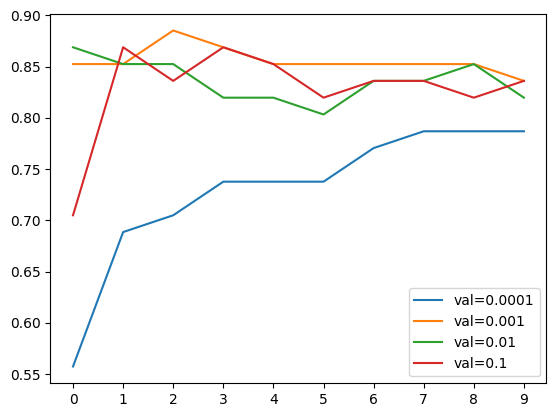

In [26]:
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [27]:
del scores[0.1]

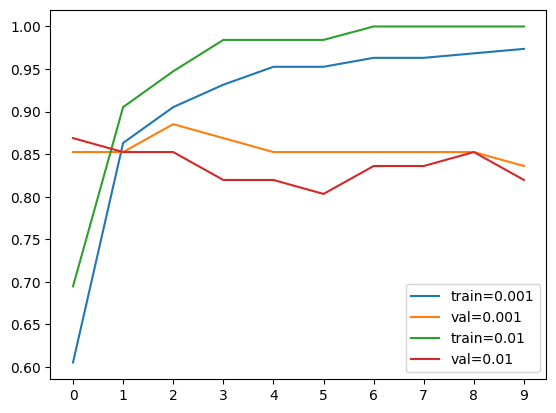

In [29]:
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label=('train=%s' % lr))
  plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [30]:
LEARNING_R = 0.001

- ### V3: one inner layer

In [32]:
scores = {}

for size in [10, 100, 1000]:
  print('SIZE: ', size)

  model = make_model(input_size=INP_SIZE, inner=True, inner_size=size, learning_rate=LEARNING_R)
  history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
  )
  scores[size] = history.history

  print('=============================================\n')

SIZE:  10
Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.9724 - accuracy: 0.5368

/home/marcelonieva/.local/share/virtualenvs/chest-3rfJv5kz/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 11s 2s/step - loss: 0.9724 - accuracy: 0.5368 - val_loss: 0.8168 - val_accuracy: 0.7705
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.8860 - accuracy: 0.5526 - val_loss: 0.6113 - val_accuracy: 0.7541
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.7016 - accuracy: 0.6947 - val_loss: 0.6077 - val_accuracy: 0.7541
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 0.6184 - accuracy: 0.6947 - val_loss: 0.5587 - val_accuracy: 0.8197
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 0.5714 - accuracy: 0.7158 - val_loss: 0.4818 - val_accuracy: 0.8525
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.5515 - accuracy: 0.7105 - val_loss: 0.4193 - val_accuracy: 0.8361
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.5125 - accuracy: 0.7632 - val_loss: 0.4248 - val_accuracy: 0.8689
Epoch 8/10
6/6 [==============================] - 7

KeyboardInterrupt: 

### Using the model

In [21]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

img = load_img('Covid19-dataset/test/Normal/0115.jpeg', target_size=(150, 150))

x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

In [22]:
preds = model.predict(X)
preds

1/1 [==============================] - 1s 693ms/step


array([[-12.430297 ,   4.3163996,   6.044539 ]], dtype=float32)